In [1]:
import numpy as np
import numpy.ma as ma
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from scipy.integrate import solve_ivp, trapezoid, OdeSolution, RK23, quad
from datetime import datetime
import tqdm 

from MCEq.core import MCEqRun
import mceq_config
from MCEq.geometry.density_profiles import EarthsAtmosphere, CorsikaAtmosphere
import crflux.models as crf
from atm import AtmospherefromTemperatureProfile, generate_atmosphere, read_station_data

# Radiosonde Atmospheres

## Real Atmospheric Observations
Let's examine some real atmospheric measurements from real radiosondes/rawinsondes. A nice plotter function will come in handy.

In [8]:
def plot_temp_profile(rws):

    plt.figure(figsize=(4, 6))
    for r in rws:
        obs = r.valid
        plt.plot(obs.temperature, obs.gph*0.001, label=str(r.dtime))

    plt.legend(fontsize=8)
    plt.title(r.st_id)
    plt.xlabel('Temperature ($^\circ$C)')
    plt.ylabel('Altitude (km)')

### Key West Data
The stations are cyptically coded. Key West is USM00072201, for example. There's a stagion decoder also available on the NCEI site. It seems that the data is segmented into new, for the past 3 years, and prior data.

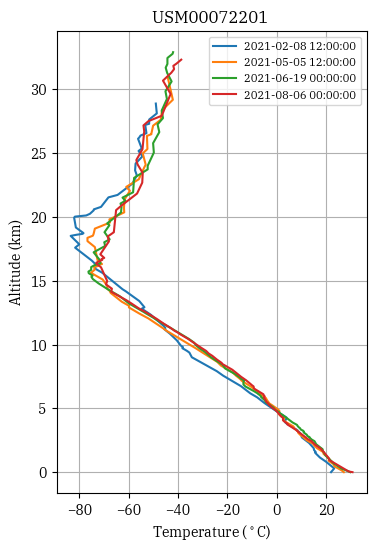

In [9]:
rw_keyw = list(read_station_data('/mnt/w/data/radiosonde/USM00072201-data.txt'))
plot_temp_profile([rw_keyw[i] for i in (77, 250, 340, 440)])

### South Pole data
South Pole (AMUNDSEN SCOTT) is __AYM00089009__. It's notably different from at least Key West as the data is only reported at regular pressure intervals (500, 400, ... etc). I changed around the `Rawinsonde` class to make dealing with missing data less onerous.

The South Pole atmosphere varies quite a bit. Compare this to a tropical atmophere like Jakarta (see below).

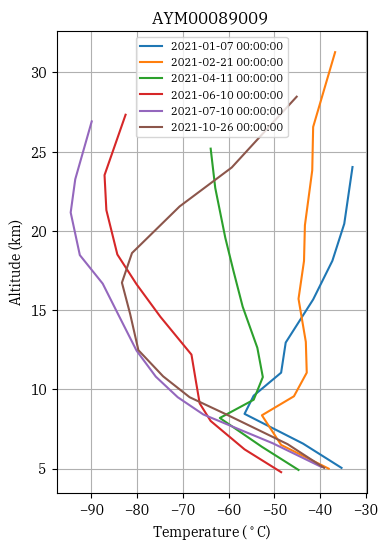

In [11]:
RW89009 = list(read_station_data('/mnt/w/data/radiosonde/AYM00089009-data.txt'))
plot_temp_profile([RW89009[i] for i in (7, 75, 157, 212, 245, 376)])

### Pickle Lake, Canada
Near the southwestern edge of Hudson Bay.

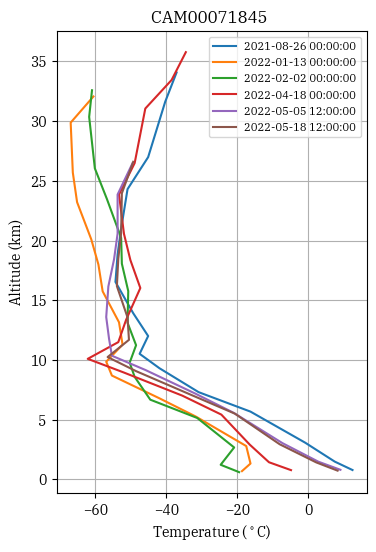

In [14]:
pickle_lake = list(read_station_data('/mnt/w/data/radiosonde/CAM00071845-data.txt'))
plot_temp_profile([pickle_lake[i] for i in (480, 760, 800, 950, 985, 1011)])

### San Diego Miramar
There's a flood advisory for 12/20/2023

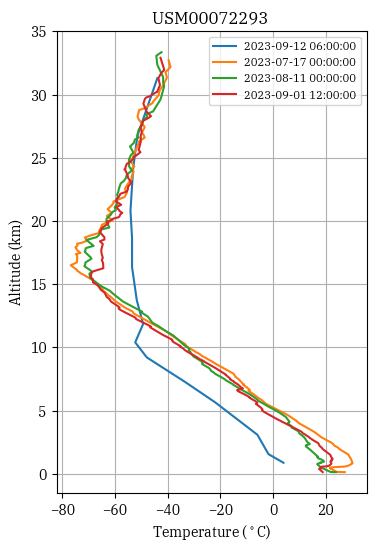

In [16]:
miramar = list(read_station_data('/mnt/w/data/radiosonde/USM00072293-data.txt'))
plt_list = [pickle_lake[-200]]
for i in (-300, -250, -200):
    plt_list.append(miramar[i])
plot_temp_profile(plt_list)

### Jakarta, Indonesia
Tropical, maritime. Wow look at how rock solid that atmosphere it. It never changes!

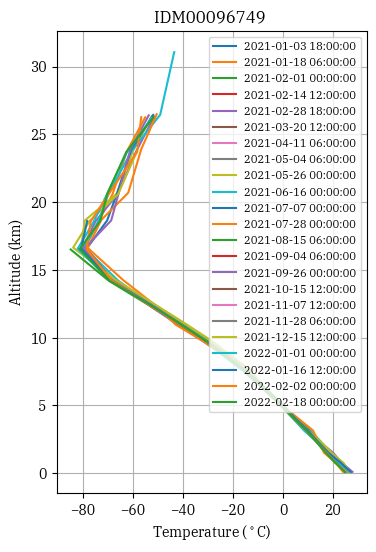

In [17]:
jakarta = list(read_station_data('/mnt/w/data/radiosonde/IDM00096749-data.txt'))
plot_temp_profile([jakarta[i] for i in range(10, 1200, 53)])

## Random Atmosphere Generator
I can generate patterns. Actually I am sure that there's plenty of real data although with generated patterns I can tweak the upper stratosphere and above, too. Plus I can guarantee some level of diversity to handle extreme cases that are rare in real atmospheres. 

### Old Way
I've abandoned the realistic altitude and pressure modeling - as it turns out it is better if I fix these. But I leave the documentation for posterity. I am still using the Weibull distribution to model ground level temperature.

#### Station Altitude
Understand what the actual station altitude distribution looks like. We have the IGRA station list.

Text(0, 0.5, 'Frequency (a.u.)')

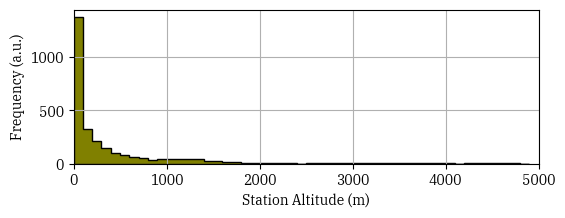

In [80]:
f = open('/mnt/w/data/radiosonde/igra2-station-list.txt', 'rt')
alt = []
for line in f.readlines():
    alt_txt = line[31:37]
    alt.append(float(alt_txt))

plt.figure(figsize=(6,2))
plt.hist(alt, bins=np.arange(0, 5000, 100), log=False, histtype='stepfilled', color='olive', ec='k');
plt.xlim(0, 5000)
plt.xlabel('Station Altitude (m)')
plt.ylabel('Frequency (a.u.)')

Surprisingly there are a lot of stations, airports presumably, at or within 100 m of sea level. There is another population of 1000-2000 m stations, I guess high plains, and then a long tail extending out to nearly 5000 m. Model this with an exponential + gaussian + uniform flat, with probabilities of 88%, 7%, and 5%, respectively.

In [87]:
a0 = np.random.uniform(0, 1, size=10000)
a1 = np.random.exponential(scale=150, size=10000)
a2 = np.random.normal(loc=1250, scale=250, size=10000)
a3 = np.random.uniform(0, 3000, size=10000)
alt = np.where(a0 > 0.95, a3, np.where(a0 > 0.88, a2, a1))

Text(0, 0.5, 'Frequency (a.u.)')

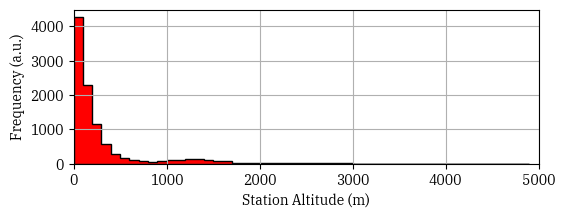

In [88]:
plt.figure(figsize=(6,2))
plt.hist(alt, bins=np.arange(0, 5000, 100), log=False, histtype='stepfilled', color='r', ec='k');
plt.xlim(0, 5000)
plt.xlabel('Station Altitude (m)')
plt.ylabel('Frequency (a.u.)')

#### Choose a Sea Level Pressure

Text(0, 0.5, 'Frequency (a.u.)')

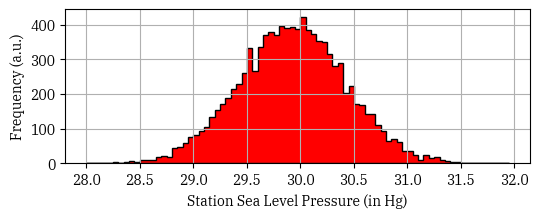

In [94]:
SLP = np.random.normal(loc=29.92, scale=0.5, size=10000)
plt.figure(figsize=(6,2))
plt.hist(SLP, bins=np.arange(28.0,32.0, 0.05), log=False, histtype='stepfilled', color='r', ec='k');
plt.xlabel('Station Sea Level Pressure (in Hg)')
plt.ylabel('Frequency (a.u.)')

Text(0, 0.5, 'Frequency (a.u.)')

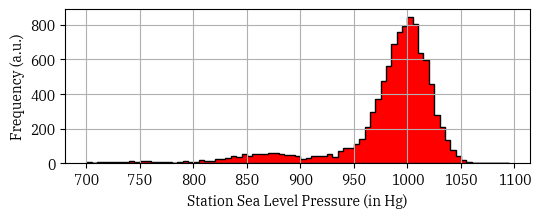

In [101]:
P0 = SLP * 33.87 * ((288.16 - 0.0065*alt) / 288.16)**5.26
plt.figure(figsize=(6,2))
plt.hist(P0, bins=np.arange(700, 1100, 5), log=False, histtype='stepfilled', color='r', ec='k');
plt.xlabel('Station Sea Level Pressure (in Hg)')
plt.ylabel('Frequency (a.u.)')

#### Choose a ground level temperature

(array([   0.,    0.,    0.,    0.,    4.,   19.,   47.,   87.,  157.,
         295.,  511.,  825., 1148., 1498., 1650., 1639., 1225.,  621.,
         228.]),
 array([-50., -45., -40., -35., -30., -25., -20., -15., -10.,  -5.,   0.,
          5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.]),
 [<matplotlib.patches.Polygon at 0x7f64efe39890>])

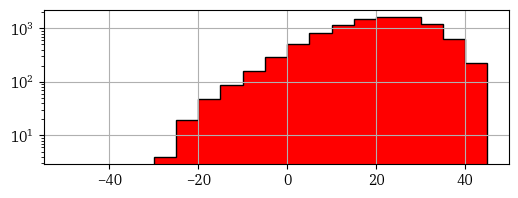

In [11]:
x = np.random.weibull(8, size=10000)*85 - 60
plt.figure(figsize=(6,2))
plt.hist(x, bins=np.arange(-50, 50, 5), histtype='stepfilled', log=True, color='r', ec='k')

#### Temperature lapses
Model as lapse rate layers:

- -0.0065 +/- 0.001 in troposphere (0 AGL up to between 8 km and 15 km MSL)
- 2 layers in tropopause -0.001 to +0.001 (0 to 5 km thick)
- +0.001 to +0.0025 in lower stratosphere (up to 10 km thick)

Text(0, 0.5, 'Altitude (km)')

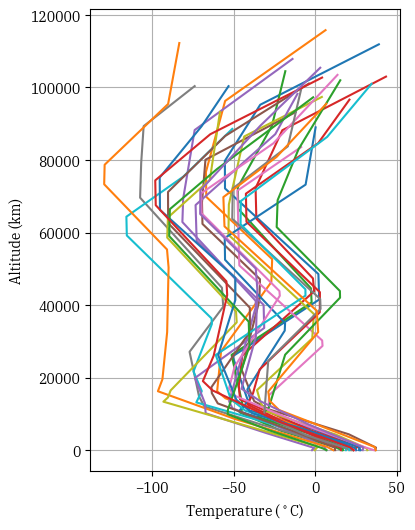

In [4]:
fig = plt.figure(figsize=(4,6))
for i in range(25):
    z, T = simulate_atmosphere()
    plt.plot(T, z)
plt.xlabel('Temperature ($^\circ$C)')
plt.ylabel('Altitude (km)')

### New Way: Simulator function
Encapsulate all of what was before into a function that directly generates AtmosphreFromTemperatureProfile objects.

Generate 5 random pseudo atmospheres.

In [21]:
a.profile[1]

array([816.50766776,  21.83416719])

(-100.0, 50.0, 0.0, 100000.0)

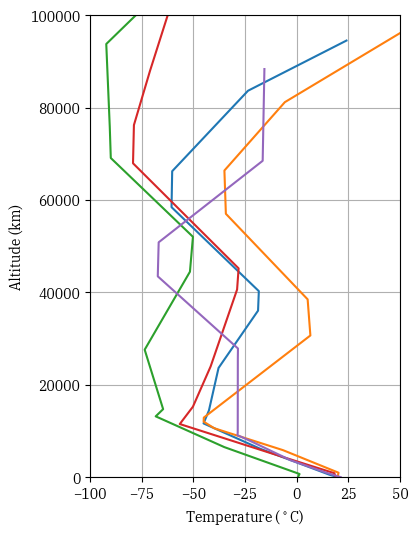

In [2]:
fig = plt.figure(figsize=(4,6))
for i in range(5):
    a = generate_atmosphere()
    z, T = a.profile.T
    plt.plot(T, z)
plt.xlabel('Temperature ($^\circ$C)')
plt.ylabel('Altitude (km)')
plt.axis((-100, 50, 0, 100000))

# On to Simulations
This has been moved out of the notebook and into the `scripts/patgen.py` file. Except one point to clean up here and that's to do with using the `int_grid`: I've been using fixed grids over all zenith angles and so off the zenith, I'm sampling _way_ up in the atmosphere.

In [3]:
a = generate_atmosphere()

mceq = MCEqRun(
    interaction_model = 'SIBYLL2.3c',
    primary_model = (crf.HillasGaisser2012, 'H3a'),
    theta_deg = 0.
)

mceq.set_density_model(a)
mceq.solve()


MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): HillasGaisser2012 H3a


In [8]:
a = generate_atmosphere()
a.h2X((50000, 100000))

array([966.39007083, 910.24472924])

# Analysis
Time to look at the data! First, it's almost certainly going to be easiest to compare the fluxes from the different atmospheres to some standard atmosphere. I could use the ICAO ISA or US Standard atmosphere but maybe it's just best to compare to an isothermal atmosphere. This also appeals to the lazy in me since MCEq already _has_ a density model that does just that.

In [9]:
from MCEq.geometry.density_profiles import IsothermalAtmosphere

The patgen utility generates random atmospheres and runs them through MCEq to produce flux files stored in `npz` format. The file contains several matrices:

- `e_grid`: the MCEq energy grid used for the computation
- `int_grid`: the X sampling grid, if any, aside from the ground level computation. Could be None
- `theta`: angular bins run in simulation
- `atm`: the atmospheric _observables_ temperature vs geopotential height and ground level pressure
- `flux`: this is the flux matrix with axes:

    - event index: the file contains multiple independent simulations, this is the index
    - grid_idx: the X sampling grid, at least 1, with 0 being ground level flux, 1 the first int_grid, etc.
    - angle: angular bins - same dimension as theta
    - energy: energy bins - same dimension as e_grid

In [141]:
def simulate_atmosphere(a, theta, mceq=None, alt_grid=None, progress=None):
    """
    Execute MCEq simulation of one atmosphere, a, over angles theta.

    Parameters
    ----------
    a : EarthsAtmosphere
        Atmosphere
    theta : float or list
        Zenith angles
    mceq : MCEqRun or None
        MCEq kernel. If None one will be created within this function. This 
        latter case may be useful for multiprocessing, if I can ever get it
        to work.
    alt_grid : list of floats
        Altitude grid to solve fluxes on - must be transformed to an X grid
        by the rotated Atmosphere.
    progress : tqdm or None
        Progress bar a la tqdm
    """
    if mceq is None: 
        mceq = MCEqRun(
            interaction_model='SIBYLL2.3c',
            primary_model = (crf.HillasGaisser2012, 'H3a'),
            theta_deg = 0.
        )

    mceq.set_density_model(a)

    theta = np.atleast_1d(theta)
    flux_A = []
    depths = []
    
    for t in theta:
        mceq.set_theta_deg(t)
        int_grid = None if alt_grid is None else a.h2X(np.array(alt_grid)*100.0)
        mceq.solve(int_grid)
        flux_X = []
        depth  = np.empty(0, 'd')
        if int_grid is not None:
            depth = np.concatenate((depth, int_grid))
            for i in range(len(int_grid)):
                flux_X.append(np.copy(
                    mceq.get_solution('total_mu-', grid_idx=i) + \
                    mceq.get_solution('total_mu+', grid_idx=i)))

        flux_X.append(np.copy(
            mceq.get_solution('total_mu-') + \
            mceq.get_solution('total_mu+')))
        depths.append(np.concatenate((depth, (a.max_X,))))
        flux_A.append(np.stack(flux_X, 0))

        if progress is not None: progress.update(1)

    return a.profile, np.stack(depths, 0), np.swapaxes(np.stack(flux_A, 0), 0, 1)

In [40]:
np.set_printoptions(linewidth=100, precision=6)

In [ ]:
atm = []
flux = []
for irun in range(131, 135):
    data = np.load(f'/mnt/w/data/MXB{irun:06d}.npz')
    atm.append(data['atm'])
    flux.append(data['flux'])

atm = np.vstack(atm)
flux = np.vstack(flux)
e_grid = data['e_grid']

In [ ]:
flux.shape

In [145]:
mceq_config.e_min = 1.0
mceq_config.e_max = 1E10
mceq = MCEqRun(
    interaction_model='SIBYLL2.3c',
    primary_model = (crf.HillasGaisser2012, 'H3a'),
    theta_deg = 0.
)

MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): HillasGaisser2012 H3a


In [146]:
z, T = data['atm'][0].T
a = AtmospherefromTemperatureProfile(alt=z, T=T, P0=data['pressure'][0])

In [151]:
a = AtmospherefromTemperatureProfile(alt=0, T=15, P0=101325, isa_fill=True)

In [152]:
res = simulate_atmosphere(a, data['theta'], alt_grid=data['alt_grid'])

MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): HillasGaisser2012 H3a


In [155]:
res[1]

array([[  802.096699,   907.907379,   964.8729  ,  1012.482145,  1024.674216],
       [  814.434821,   921.877021,   979.721116,  1028.06474 ,  1040.444891],
       [  853.41451 ,   966.012402,  1026.632903,  1077.29729 ,  1090.271808],
       [  925.747678,  1047.917824,  1113.693376,  1168.66694 ,  1182.745094],
       [ 1046.0292  ,  1184.132543,  1258.489622,  1320.637031,  1336.552562],
       [ 1245.361407,  1409.919072,  1498.526963,  1572.58888 ,  1591.556165],
       [ 1597.493512,  1808.966884,  1922.857944,  2018.063077,  2042.446646],
       [ 2320.877654,  2629.703927,  2796.113016,  2935.264025,  2970.909147],
       [ 4429.079785,  5033.898796,  5360.722492,  5634.481947,  5704.675608],
       [17933.085056, 22903.21045 , 26681.494772, 31954.459008, 36320.35431 ]])

In [156]:
ref = res[2]

In [404]:
def scale_height(T_C):
    """
    Return isothermal scale height in km given a temperature
    """
    return 8.314 * (T_C + 273.16) / (0.029 * 9.8) * 0.001

In [129]:
X0 = data['pressure'][0] / 10 / 9.8
ref_flux = []
for theta in data['theta']:
    #a = IsothermalAtmosphere('Simville', 'Summer', X0=X0, hiso_km=7.0)
    a = AtmospherefromTemperatureProfile(0, 288, P0 = data['pressure'][0], isa_fill=True)
    mceq.set_density_model(a)
    mceq.set_theta_deg(theta)
    int_grid = a.h2X(data['alt_grid']*100.)
    mceq.solve(int_grid=int_grid)
    mu = []
    for idx in range(len(int_grid)):
        mu.append(np.copy(mceq.get_solution('total_mu-', grid_idx=idx) + 
                          mceq.get_solution('total_mu+', grid_idx=idx)))
    mu.append(np.copy(mceq.get_solution('total_mu-') + mceq.get_solution('total_mu+')))
    ref_flux.append(np.stack(mu, 0))

ref = np.swapaxes(np.stack(ref_flux, 0), 0, 1)

In [53]:
def integrateE(theta, e_grid, flux, exposure=60):
    n_mu = trapezoid(e_grid*flux, dx=0.1) * 1E4
    t2 = 0.5*(theta[:-1] + theta[1:])
    dt2 = np.deg2rad(np.diff(theta))
    return t2, dt2 * 0.5*(n_mu[:-1] + n_mu[1:]) * np.sin(np.deg2rad(t2)) * 2*np.pi * exposure


In [167]:
def compare_atmospheres(data, ref, run, *ipats, grid_idx=0, integration_time=86400):
    
    X = data['int_grid']
    flux = data['flux']
    e_grid = data['e_grid']
    
    frat = flux[...,:50] / ref[...,:50]
    
    fig = plt.figure(figsize=(10,3))
    gs = mpl.gridspec.GridSpec(1, 5, figure=fig, wspace=1, hspace=0.2)
    ax1 = fig.add_subplot(gs[0:1])
    ax2 = fig.add_subplot(gs[1:3])
    ax3 = fig.add_subplot(gs[3:5])
    colors = ('k', 'r', 'b', 'g', 'y', 'magenta', 'orange')
    markers = ('s', 'v', 'o')
    linestyles = ('-', '--', '-.')

    lines  = []
    labels = []

    for iser, ipat in enumerate(ipats):
        ls = linestyles[iser]
        
        z, T = data['atm'][ipat].T

        ax1.plot(T, 0.001*z, color=colors[iser], linestyle=ls)

        for icol, i in enumerate((1, 3, 6, 8)):
            labels.append(f'{i*10}$^\circ$')
            line, = ax2.semilogx(e_grid[:50], frat[ipat,grid_idx,i], color=colors[icol], linestyle=ls)
            lines.append(line)
    
        t2, n_mu = integrateE(
            data['theta'], e_grid, flux[ipat, grid_idx], exposure=integration_time)
        t2, n_iso = integrateE(
            data['theta'], e_grid, ref[grid_idx], exposure=integration_time)
    
        arat = n_mu / n_iso
        arrx = np.mean(arat) # Normalize the angular flux
    
        # Spline 'em
        rel_ang_flux = UnivariateSpline(t2, n_mu/n_iso/arrx, s=0)
    
        ax3.errorbar(t2, n_mu/n_iso/arrx, np.sqrt(n_mu)/n_iso/arrx, 
                     color=colors[iser], marker=markers[iser], linestyle='', ms=3)
        
        a = np.linspace(5, 95, 181)
        ax3.plot(a, rel_ang_flux(a), linestyle=ls, color=colors[iser], lw=0.5)
    
    ax1.set_xlabel('Temperature (C)')
    ax1.set_ylabel('Altitude (km)')
    ax1.set_xlim((-125, 40))
    ax1.set_ylim((0, 80))
    ax1.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(4))
    ax1.grid(True, which='both')
    
    ax2.set_xlim(1, 1E5)
    #ax2.set_ylim(0.75, 1.33)
    ax2.set_xlabel('Muon Energy (GeV)')
    ax2.set_ylabel('Flux Rel. to reference atmosphere')
    ax2.legend(lines[0:4], labels[0:4], fontsize=8)
    
    ax3.set_xlim(0, 90)
    ax3.set_xlabel(r'$\theta$ (degrees)')
    ax3.set_ylabel('Normalized Angular Spectrum')

    fig.suptitle(f'MCEq RUN {run:04d} Int. Time {integration_time} s')

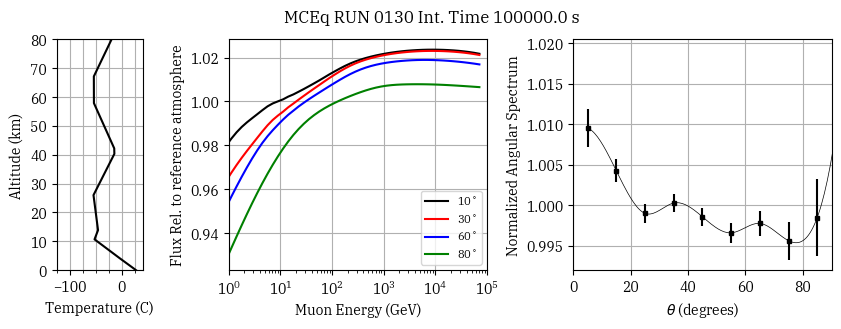

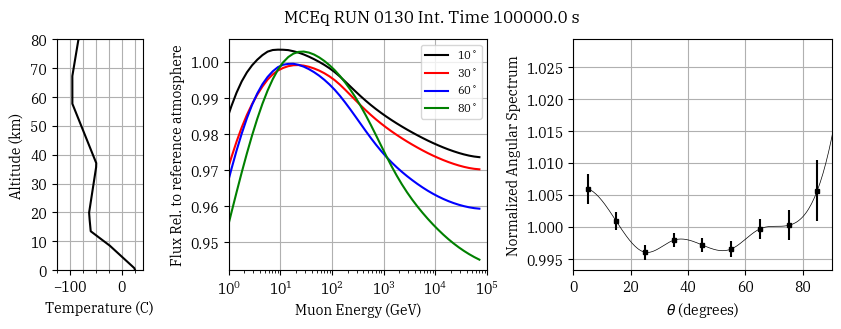

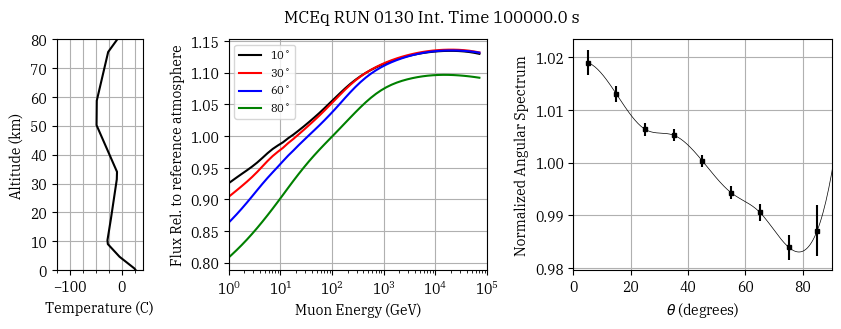

In [183]:
compare_atmospheres(data, ref, 130, 6, grid_idx=4, integration_time=1E5)
compare_atmospheres(data, ref, 130, 7, grid_idx=4, integration_time=1E5)
compare_atmospheres(data, ref, 130, 8, grid_idx=4, integration_time=1E5)

In [228]:
n_mu = UnivariateSpline(
    np.deg2rad(data['theta']), 
    trapezoid(data['flux'][3,4]*mceq.e_grid) * 1E4 * 0.1 * np.log(10) * 2*np.pi, k=3, s=0.5)
quad(lambda t: n_mu(t)*np.sin(t), 0.0, np.pi/2)

(100.47239971722598, 8.597074203131682e-07)

In [431]:
def int_energy_range(e, phi, e0, e1):
    phiLog = UnivariateSpline(np.log10(e), np.log10(phi*e), s=0.0)
    return quad(lambda y: 10**phiLog(y) * 1E4 * np.log(10), np.log10(e0), np.log10(e1)) 

In [483]:
def build_ea_tab(flux, stride=10):
    return np.vstack([
        trapezoid(flux[...,stride*i:stride*(i+1)]*e_grid[stride*i:stride*(i+1)], dx=0.1)*1E4*np.log(10)*2*np.pi 
        for i in range(0, 4)])

In [485]:
np.set_printoptions(precision=4, suppress=True)
100*(build_ea_tab(flux[0,4,[0,3,9]], stride=5) / build_ea_tab(ref[4, [0,3,9]], stride=5) - 1)

array([[-2.8501, -4.3185, -3.4464],
       [-1.0127, -1.9841, -0.4869],
       [-0.0853, -0.6297,  1.7867],
       [ 0.1968, -0.1387,  2.7418]])

In [433]:
int_energy_range(e_grid[0:50], flux[0,4,0,0:50], 1.0, 1000.0)

(41.94972332908002, 5.848590327087793e-07)

In [438]:
e_grid[:50:10]

array([   0.8913,    8.9125,   89.1251,  891.2509, 8912.5094])

In [358]:
t_alt = []
inten = []
for i, p in enumerate(atm):
    z, T = p.T
    a = AtmospherefromTemperatureProfile(z, T, P0=101325.)
    t_alt.append(a._Tspline(10000.0))
    inten.append(np.average(r[i,4,0,7:9]))
t_alt = np.array(t_alt)
inten = np.array(inten)

(200.0, 300.0, 0.9, 1.1)

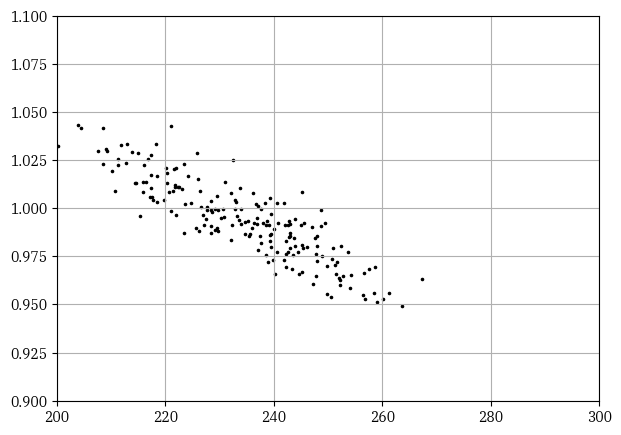

In [384]:
plt.scatter(t_alt, inten, s=2.5, color='black')
plt.axis((200, 300, 0.9, 1.1))

## First attempt at temperature reconstruction

In [259]:
from sklearn import svm

In [503]:
X = []
y = []
scale = 100.0

for i, p in enumerate(atm):
    z, T = p.T
    a = AtmospherefromTemperatureProfile(z, T, P0=101325.)
    y.append(float(a._Tspline(15000.)))
    f_v = scale*(build_ea_tab(flux[i,4,[0,3,9]], stride=5) / build_ea_tab(ref[4,[0,3,9]], stride=5) - 1).flatten()
    X.append(f_v)

print (len(X), len(y))

400 400


In [504]:
regr = svm.SVR(kernel='linear', tol=1E-4, C=1.0)
regr.fit(X[:300], y[:300])

SVR(kernel='linear', tol=0.0001)

(150.0, 300.0, 150.0, 300.0)

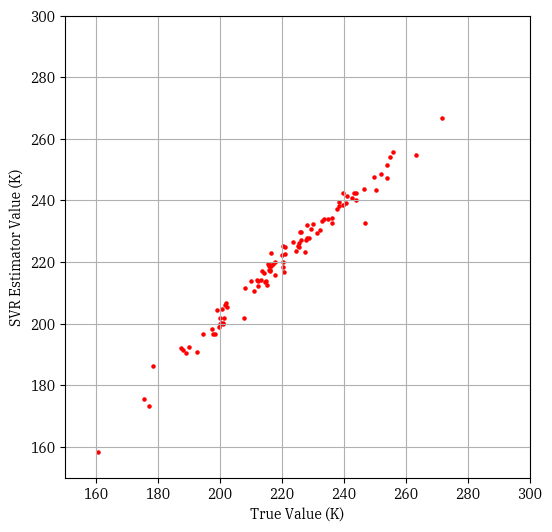

In [505]:
fig = plt.figure(figsize=(6,6))
#plt.scatter(y[0:300], regr.predict(X[:300]), s=2.5, color='k')
plt.scatter(y[300:], regr.predict(X[300:]), s=5, color='r')
plt.xlabel('True Value (K)')
plt.ylabel('SVR Estimator Value (K)')
plt.axis((150, 300, 150, 300))